## Import libraries, create connection with db

In [119]:
import psycopg2
from psycopg2 import sql
import psycopg2.extras
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

load_dotenv()

def connect_to_db():
    try:
        conn = psycopg2.connect(host=os.getenv('DB_HOST'), port=os.getenv('DB_PORT'), database=os.getenv('DB_NAME'), user=os.getenv('DB_USER'), password=os.getenv('DB_PASS'))
        cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
        return conn, cur
    except:
        print("Unable to connect to the database")

### Trend Analysis on BZ and ES

In [144]:
# Connect and query the data
conn, cursor = connect_to_db()
query = sql.SQL("""
    SELECT 
        COALESCE(bz.month, es.month) AS month,
        bz.volume AS bz_volume,
        bz.close AS bz_close,
        es.volume AS es_volume,
        es.close AS es_close
    FROM 
        (SELECT 
            time_bucket('1 month', timestamp) AS month,
            AVG(volume) AS volume,
            LAST(close, timestamp) AS close
        FROM bz
        GROUP BY month) bz
    FULL JOIN 
        (SELECT 
            time_bucket('1 month', timestamp) AS month,
            AVG(volume) AS volume,
            LAST(close, timestamp) AS close
        FROM es
        GROUP BY month) es
    ON bz.month = es.month
    ORDER BY month DESC;
""")    
cursor.execute(query)
results = cursor.fetchall()

df = pd.DataFrame(results, columns=['month', 'bz_volume', 'bz_close', 'es_volume', 'es_close'])
df['month'] = pd.to_datetime(df['month'])
df = df.set_index('month')

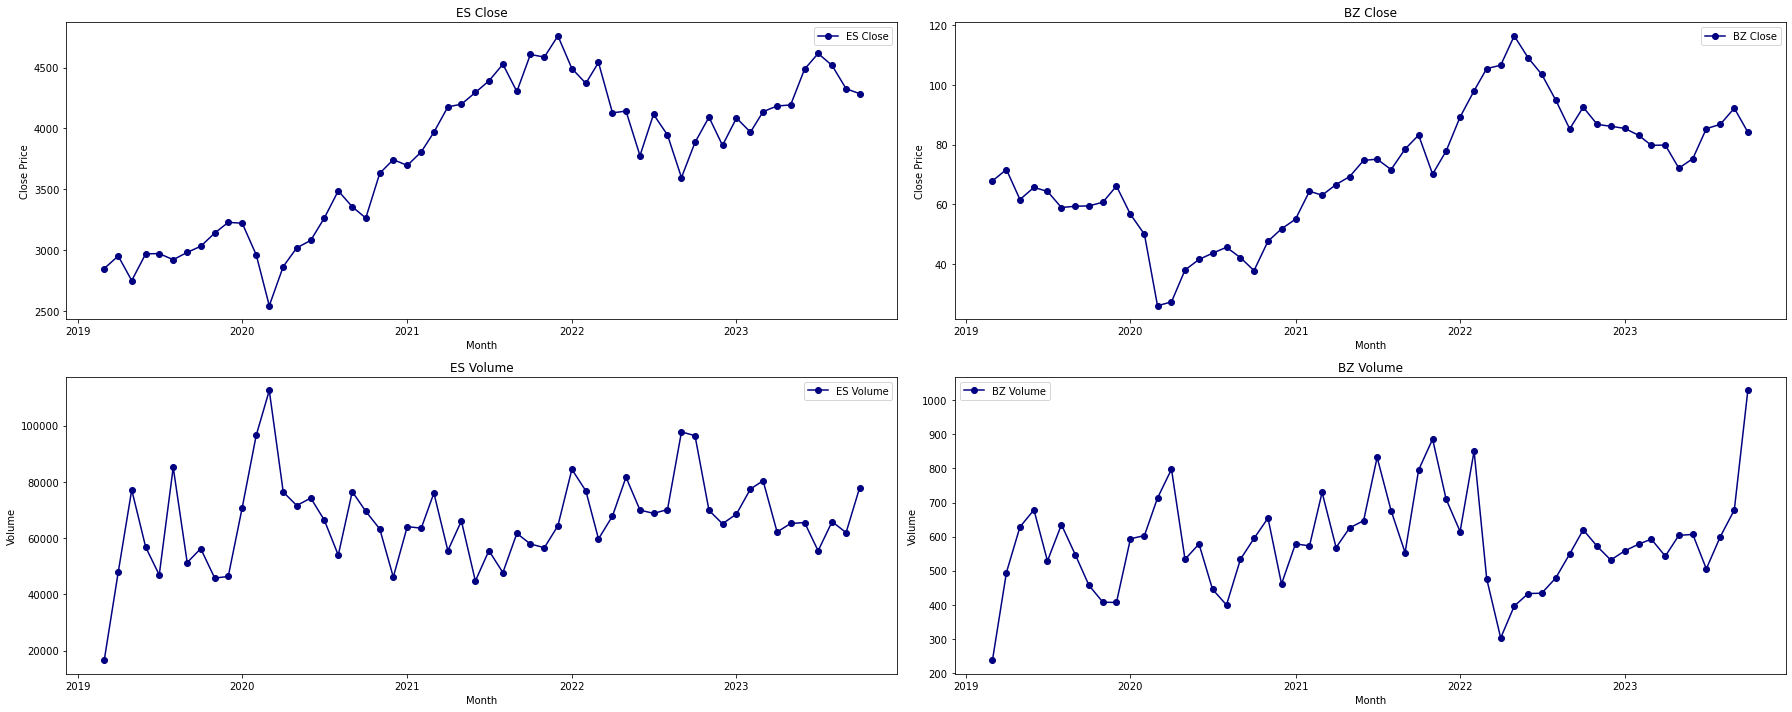

In [150]:
def plot_trends(df):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 10))

    # Plotting es close
    axes[0, 0].plot(df.index, df['es_close'], marker='o', label='ES Close', color='navy')
    axes[0, 0].set_title('ES Close')
    axes[0, 0].set_xlabel('Month')
    axes[0, 0].set_ylabel('Close Price')
    axes[0, 0].legend()

    # Plotting bz close
    axes[0, 1].plot(df.index, df['bz_close'], marker='o', label='BZ Close', color='navy')
    axes[0, 1].set_title('BZ Close')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Close Price')
    axes[0, 1].legend()

    # Plotting es volume
    axes[1, 0].plot(df.index, df['es_volume'], marker='o', label='ES Volume', color='navy')
    axes[1, 0].set_title('ES Volume')
    axes[1, 0].set_xlabel('Month')
    axes[1, 0].set_ylabel('Volume')
    axes[1, 0].legend()

    # Plotting bz volume
    axes[1, 1].plot(df.index, df['bz_volume'], marker='o', label='BZ Volume', color='navy')
    axes[1, 1].set_title('BZ Volume')
    axes[1, 1].set_xlabel('Month')
    axes[1, 1].set_ylabel('Volume')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

plot_trends(df)

### SMA and EMA Analysis on Close Prices for BZ through 2023

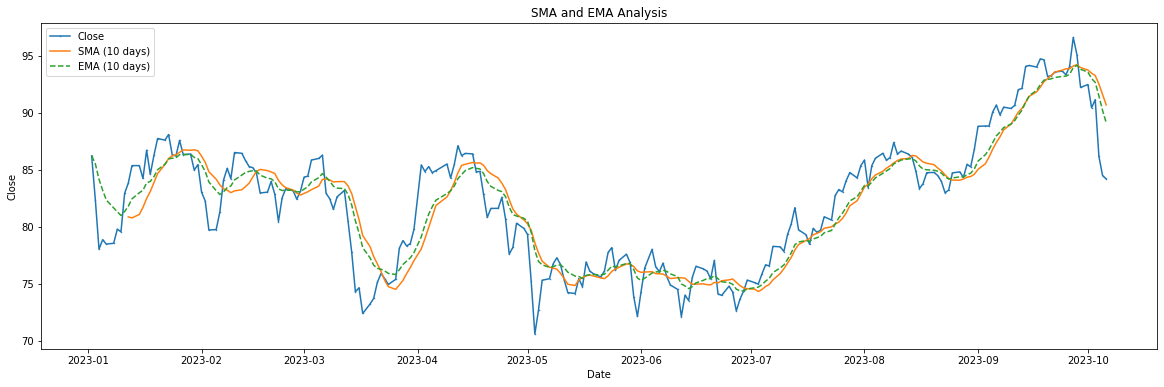

In [136]:
# Connect and query the data
conn, cursor = connect_to_db()
query = sql.SQL("""
    SELECT
        time_bucket('1 day', timestamp) AS day, 
		LAST(close, timestamp) AS close
    FROM bz
    WHERE timestamp >= '2023-01-01'
    GROUP BY day
    ORDER BY day;
""")    
cursor.execute(query)
results = cursor.fetchall()

# Save the results to a dataframe
df = pd.DataFrame(results, columns=['day', 'close'])
df['day'] = pd.to_datetime(df['day'])
df = df.set_index('day')

# Calculate SMA (Simple Moving Average) and EMA (Exponential Moving Average) and plot the data
def plot_SMA_EMA(df, window_size=10, span=10):
    # Calculate SMA (Simple Moving Average) and EMA (Exponential Moving Average)
    df['sma'] = df['close'].rolling(window=window_size).mean()
    df['ema'] = df['close'].ewm(span=span, adjust=False).mean()


    plt.figure(figsize=(20, 6))
    plt.plot(df.index, df['close'], marker='o', markersize=.5, linestyle='-', label='Close')
    plt.plot(df.index, df['sma'], linestyle='-', label=f'SMA ({window_size} days)')
    plt.plot(df.index, df['ema'], linestyle='--', label=f'EMA ({span} days)')
    
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.title('SMA and EMA Analysis')

    plt.show()

plot_SMA_EMA(df, window_size=10, span=10)

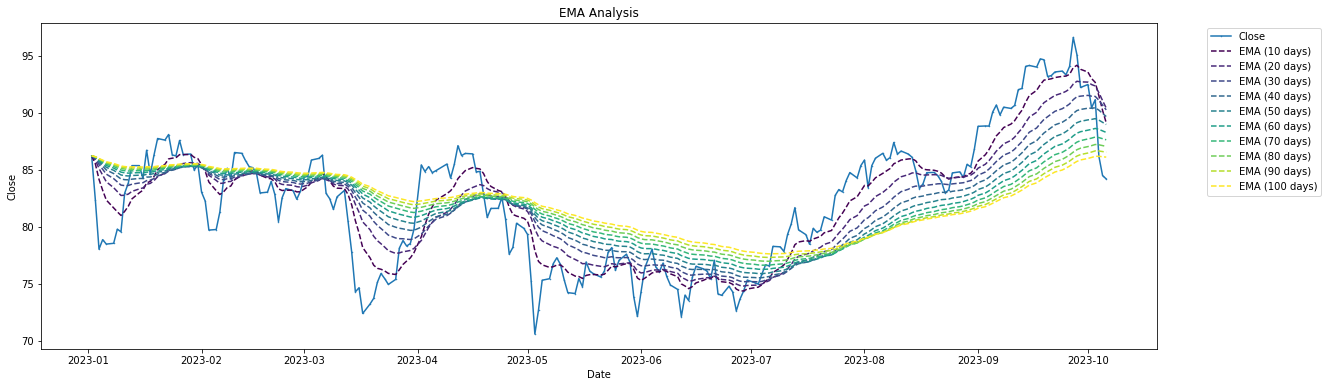

In [135]:
def plot_EMAs(df, spans=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]):
    plt.figure(figsize=(20, 6))
    plt.plot(df.index, df['close'], marker='o', markersize=.5, linestyle='-', label='Close')

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(spans)))

    for i, (span, color) in enumerate(zip(spans, colors)):
        df[f'ema_{span}'] = df['close'].ewm(span=span, adjust=False).mean()
        plt.plot(df.index, df[f'ema_{span}'], linestyle='--', label=f'EMA ({span} days)', color=color)
    
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.title('EMA Analysis')

    plt.show()

plot_EMAs(df)
